#  Practice 3 : Analysis of trade scores
 
Authors:
- Martín Hijar Jiménez
- Eduardo Salgado Díaz del Río

8 January 2022

Subject: Machine Learning - Master's Degree in Data Science 

Despite all the things we have seen above, we have decided to generate a prediction model of the different reviews we found in the yelp_academic_dataset_review file.

Our goal is to make a NLP model, to familiarize ourselves with this technology and its main concepts in order to be able to make a relatively good model.

We are going to study the text of the reviews we have and try to predict how many stars will be awarded to these reviews.

Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score



from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from keras.utils import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
# from keras.utils import to_categorical

import tensorflow as tf    
tf.compat.v1.disable_v2_behavior()
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

Read Data

In [2]:
business = pd.read_parquet('../input/yelppp/business.parquet')
review_all = pd.read_parquet('../input/yelppp/review.parquet')

In [3]:
a = business[business['categories'].str.contains('Restaurant') == True]
rev = review_all[review_all.business_id.isin(a['business_id']) == True]

We randomly sampled the review data set for 350 000 reviews. Then we split between train and test.

In [4]:
seed = 42
n_sample = 350000
n_split = 280000

In [5]:
rev_samp = rev.sample(n = n_sample, random_state = seed)
train = rev_samp[0:n_split]
test = rev_samp[n_split:]

In [6]:
train.shape, test.shape

((280000, 9), (70000, 9))

,text,stars
1305110,I'm not a religious woman but I do think this ...,5.0
4150194,Miguel was a fabulous bartender!!! Super nice...,5.0
2186108,I had the chicken mole. It was excellent. ...,4.0
738553,Waited next door at the Maple Leaf for a table...,3.0
6372467,Given the space and limited number of small ta...,4.0


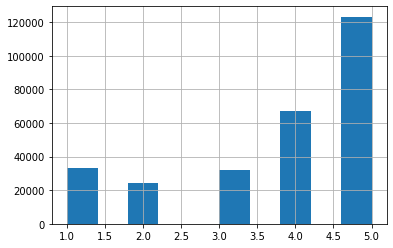

In [7]:
train = train[['text', 'stars']]
train['stars'].hist();train.head()

This sample is quite skewed towards 4 and mostly 5-star reviews. We don't think this is something we want to balance the data set for, but it is something we will take into account when analyzing the accuracy of the model.

In [8]:
train = pd.get_dummies(train, columns = ['stars'])
train.head()

,text,stars_1.0,stars_2.0,stars_3.0,stars_4.0,stars_5.0
1305110,I'm not a religious woman but I do think this ...,0,0,0,0,1
4150194,Miguel was a fabulous bartender!!! Super nice...,0,0,0,0,1
2186108,I had the chicken mole. It was excellent. ...,0,0,0,1,0
738553,Waited next door at the Maple Leaf for a table...,0,0,1,0,0
6372467,Given the space and limited number of small ta...,0,0,0,1,0


We divide the different stars (from 1 to 5) into dummy columns in order to start training our model.

In [9]:
test = test[['text', 'stars']]
test = pd.get_dummies(test, columns = ['stars'])
train.shape, test.shape

((280000, 6), (70000, 6))

So now we have a training set with 280,000 reviews and a test set with 70,000.

In [10]:
# set frac = 1. to use the entire sample
frac = .1
train_samp = train.sample(frac = frac, random_state = seed)
test_samp = test.sample(frac = frac, random_state = seed)
train_samp.shape, test_samp.shape

((28000, 6), (7000, 6))

Naive Bayes Linear Model

We are going to establish a reference model. Researching NLP problems we have seen that a Naive Bayes linear classifier is a really solid baseline for NLP problems.

The Naive Bayes algorithm uses Bayes' theorem to calculate the conditional probability of a rating given some text. Of course, this is rather vague. Let's say our review is "This restaurant is terrible." You could take that 4-word phrase and see how many times it appears in 1-star reviews and then see how many times it appears in 5-star reviews. With those counts, you could calculate a likelihood ratio that tells you which type of review appears most often in that text.

How many reviews have that exact text "This restaurant is terrible"? We would never get satisfactory results because the reviews would all have unique text. A simple way to fix this is to remove all sentence structure and simply use a bag-of-words representation of the review text. "This restaurant is terrible" becomes a vector with counts of "This", "restaurant", "is", "terrible".

As a final preprocessing step, we are actually going to use tfidf (term frequency, inverse document frequency) instead of simply counting words to represent word vectors. Essentially, this gives weights to words to show how important a word is to a particular review, so frequently used words, such as "the", have a lower weight since they appear so frequently in almost every review.

This tokenization and tfidf calculation is done with sklearn's TfidfVectorizer method.

In [11]:
# max_features is an upper bound on the number of words in the vocabulary
max_features = 2000
tfidf = TfidfVectorizer(max_features = max_features)

Once the text is prepared, we can apply Bayes' theorem. We want to find the answers to the following questions: given the review "This restaurant is terrible", what is the likelihood that it is a 1-star review and what is the likelihood that it is a 5-star review (this works the same for ratings from 1 to 5 stars, it is just simpler to demonstrate with a binary classification)? Another way to ask this question is: what is the probability of a 1-star review given the words "This", "restaurant", "is", "terrible"? If we assume that each word is independent of the others (a very simplified assumption, but the source of the name Naive Bayes), we can calculate this as follows:

*P(this|1 star)×P(restaurant|1 star)×P(is|1 star)×P(terrible|1 star)*

One issue is what to do with words that we haven't encountered in a review category. Should we pretend that "amazing" never appears in a 1-star review simply because we haven't seen it yet? This would cause many problems, so we get around it by adding 1 to all word counts. This essentially means - yes, we haven't seen that word yet, but we acknowledge that it is possible it could occur.

After all this, you can calculate the probability of "This restaurant is terrible" given a 1-star review and given a 5-star review. Once calculated, we simply predict the rating with the higher probability or divide them and predict 1 star if positive and 5 stars if negative.

We take a NBFeatures class to include all the Naive Bayes logic.

In [12]:
class NBFeatures(BaseEstimator):
    def __init__(self, alpha):
        self.alpha = alpha
        
    def preprocess_x(self, x, r):
        return x.multiply(r)
    
    def pr(self, x, y_i, y):
        p = x[y == y_i].sum(0)
        return (p + self.alpha)/((y==y_i).sum()+self.alpha)
    
    def fit(self, x, y = None):
        self._r = sparse.csr_matrix(np.log(self.pr(x, 1, y) /self.pr(x, 0, y)))
        return self
    
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb

Then use the sklearn Pipeline to neatly combine multiple steps. This first processes the data by tokenizing and calculating the tfidf (using the previously created tfidfVectorizer). It inputs that into the NBFeatures method to generate all the Naive Bayes features. Finally, those features are input into the logistic regression, where the parameters are learned.

In [13]:
lr = LogisticRegression()
nb = NBFeatures(1)
p = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])

The star ratings are predicted one at a time, so below we go through the binary ratings columns and generate probability predictions for each class.

In [14]:
class_names = ['stars_1.0', 'stars_2.0', 'stars_3.0', 'stars_4.0', 'stars_5.0']
scores = []
preds = np.zeros((len(test_samp), len(class_names)))
for i, class_name in enumerate(class_names):
    train_target = train_samp[class_name]    
    cv_score = np.mean(cross_val_score(estimator = p, X = train_samp['text'].values, 
                                      y = train_target, cv = 3, scoring = 'accuracy'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    p.fit(train_samp['text'].values, train_target)
    preds[:,i] = p.predict_proba(test_samp['text'].values)[:,1]

CV score for class stars_1.0 is 0.9282856439522202
CV score for class stars_2.0 is 0.9152500303949603
CV score for class stars_3.0 is 0.8902857063530529
CV score for class stars_4.0 is 0.7692500198188075
CV score for class stars_5.0 is 0.8047142711860144


We use 3 cross validation to estimate the accuracy.

In [15]:
t = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(preds, axis = 1))
print(t)

              precision    recall  f1-score   support

           0       0.63      0.79      0.70       831
           1       0.43      0.16      0.24       607
           2       0.48      0.25      0.33       795
           3       0.50      0.37      0.42      1730
           4       0.69      0.92      0.79      3037

    accuracy                           0.62      7000
   macro avg       0.55      0.50      0.49      7000
weighted avg       0.59      0.62      0.59      7000



The first major development in NLP that we wanted to learn about was embeddings, or word vectors. The basic Word2Vec technique attempts to represent the meaning of words by computing the context in which they occur. Since we're dealing with natural language, this will be thousands of different contexts, resulting in vectors with potentially millions of dimensions. For example, you might see "it" appear in context as "it was", "it wasn't", "it become", "it sat", and so on. Since it doesn't appear in thousands of other contexts, we end up with a long vector [0, 1, 0, 0, 0, 0, 2, 0, ...] with a 0 in the context didn't see that word, and how many times it occurs elsewhere.

It turns out that you can represent most information (or vector spaces) in fewer dimensions, so word vectors use dimensionality reduction techniques to reduce the dimensionality to 25-300. For a more detailed overview of the basic ideas, this core is a good code-centric guide.

This may not seem very useful at first glance, but these word vectors tell us the relationship between words. Since they are vectors, we can use them for calculations.

The bad news is that training your own word vectors requires a lot of text data. Fortunately, there are several very good precomputed vectors (or embeddings) freely distributed and available for modeling. We are using GloVe embeddings from the Twitter corpus here. There are GloVe embeds from other sources, such as Wikipedia or Common Crawl, and others, such as FastText. Knowing from research that comments often contain substandard English and unusual punctuation/language. We thought Twitter seemed appropriate

GloVe embedding from Twitter corpus:

https://nlp.stanford.edu/projects/glove/ 

In [16]:
embed_size = 200 
# max number of unique words 
max_features = 20000
# max number of words from review to use
maxlen = 200

# File path
embedding_file = '../input/yelppp/glove.twitter.27B.200d.txt'

# read in embeddings
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file, encoding='utf-8'))

In [17]:
class_names = ['stars_1.0', 'stars_2.0', 'stars_3.0', 'stars_4.0', 'stars_5.0']
y = train_samp[class_names].values

We have to take the extra step of padding the vectors so they are all the same length. Keras requires this, and the pad_sequences method makes it easy.

In [18]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_samp['text'].values))
X_train = tokenizer.texts_to_sequences(train_samp['text'].values)
X_test = tokenizer.texts_to_sequences(test_samp['text'].values)
x_train = pad_sequences(X_train, maxlen = maxlen)
x_test = pad_sequences(X_test, maxlen = maxlen)

 One problem that can arise when using pretrained embeddings is that if a word does not appear in the embedding training dataset, then there is no vector for it in the embedding file. You can randomly initialize the vectors for words that don't appear in the embedding vectors, or you can use multiple embedding files (like glove + fasttext) to try and cover a larger vocabulary. We are just leaving them as empty vectors, but you should try a variety of methods to see which works best for your new dataset.

In [19]:
word_index = tokenizer.word_index

nb_words = min(max_features, len(word_index))

embedding_matrix = np.zeros((nb_words, embed_size))
missed = []
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missed.append(word)

Many of the words seem to be specific to restaurant reviews, with many restaurant names, food names, and words that may not appear frequently in tweets. One area where we could potentially increase accuracy is by fixing all the contractions that are not present in the embedding vocabulary. We could also further improve accuracy by stemming and lemmatizing the tokens.

In [20]:
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(40, return_sequences=True))(x)
x = Bidirectional(GRU(40, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation = 'sigmoid')(conc)

model = tf.keras.Model(inputs = inp, outputs = outp)
# patience is how many epochs to wait to see if val_loss will improve again.
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)
checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, filepath = 'yelp_lstm_gru_weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

2023-01-08 16:07:28.315132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 16:07:28.405168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 16:07:28.405990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 16:07:28.409519: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [21]:
model.fit(x_train, y, batch_size = 512, epochs = 20, validation_split = .1,
          callbacks=[earlystop, checkpoint])

Train on 25200 samples, validate on 2800 samples
Epoch 1/20
25200/25200 [==============================] - ETA: 0s - loss: 0.4936 - acc: 0.7720

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


25200/25200 [==============================] - 26s 1ms/sample - loss: 0.4936 - acc: 0.7720 - val_loss: 0.4457 - val_acc: 0.8091
Epoch 2/20
25200/25200 [==============================] - 24s 944us/sample - loss: 0.4280 - acc: 0.8194 - val_loss: 0.3965 - val_acc: 0.8332
Epoch 3/20
25200/25200 [==============================] - 23s 923us/sample - loss: 0.3689 - acc: 0.8416 - val_loss: 0.3453 - val_acc: 0.8446
Epoch 4/20
25200/25200 [==============================] - 24s 945us/sample - loss: 0.3300 - acc: 0.8540 - val_loss: 0.3166 - val_acc: 0.8559
Epoch 5/20
25200/25200 [==============================] - 24s 971us/sample - loss: 0.3083 - acc: 0.8614 - val_loss: 0.3054 - val_acc: 0.8582
Epoch 6/20
25200/25200 [==============================] - 24s 949us/sample - loss: 0.2934 - acc: 0.8659 - val_loss: 0.2959 - val_acc: 0.8604
Epoch 7/20
25200/25200 [==============================] - 24s 935us/sample - loss: 0.2823 - acc: 0.8706 - val_loss: 0.2894 - val_acc: 0.8659
Epoch 8/20
25200/25200 [==

In [23]:
y_test = model.predict([x_test], batch_size=1024, verbose = 1)

In [24]:
model.evaluate(x_test, test_samp[class_names].values, verbose = 1, batch_size=1024)

[0.28812773728370666, 0.86985713]

In [25]:
v = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(y_test, axis = 1))
print(v)

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       831
           1       0.48      0.35      0.40       607
           2       0.46      0.43      0.45       795
           3       0.55      0.51      0.53      1730
           4       0.77      0.84      0.81      3037

    accuracy                           0.66      7000
   macro avg       0.59      0.58      0.58      7000
weighted avg       0.65      0.66      0.65      7000



Although our model is not perfect, the neural network approach increased precision, recall and f1-score which is quite significant. The biggest improvement was seen in 2-4 star reviews, which were previously weaker areas for the naive bayes model. 

We believe it is reasonable that ratings from 2 to 4 stars are the most difficult to get right.

We find it reasonable that ratings of 2 to 4 stars are the most difficult to get right. 

Let's use an example to clarify our thinking:
Actually when we ourselves write a good but not excellent review, the fact of putting 3 or 4 stars is completely subjective and personal, so it is difficult to predict such a random behavior, which varies so much and is not subject to a rational rule.

Or when we have a bad experience but not a catastrophic one. What is the difference between 2 or 3 stars? We do not know how to put a rational rule to differentiate when to put one or the other.

In [32]:
# importing SHAP
import shap
import warnings

# sampling data from the training and test set to reduce time-taken
X_train_sample = shap.sample(x_train, 20)
X_test_sample = shap.sample(x_test, 3)

# creating the KernelExplainer using the logistic regression model and training sample
SHAP_explainer = shap.KernelExplainer(model.predict, X_train_sample)
# run block of code and catch warnings
with warnings.catch_warnings():
 # ignore all caught warnings
    warnings.filterwarnings("ignore")
    # calculating the shap values of the test sample using the explainer 
    shap_vals = SHAP_explainer.shap_values(X_test_sample)

  0%|          | 0/3 [00:00<?, ?it/s]

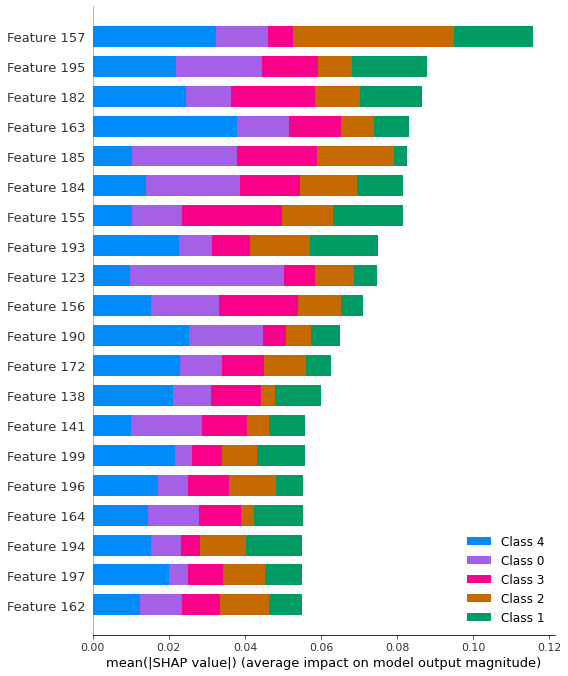

In [58]:
shap.summary_plot(shap_vals, X_test_sample)

Each characteristic corresponds to a word that has a greater or lesser influence on whether the text to which it belongs is rated 1, 2, 3, 4 or 5 stars

The characteristic to which it belongs can be seen in the dictionary created above *word_index*.

In [75]:
dict(list(word_index.items())[0:5])

{'the': 1, 'and': 2, 'a': 3, 'i': 4, 'to': 5}

In [70]:
len(word_index)

38439

As we can see, there is a very high number of words. 

The training time has been quite long. Even though we do not have the computational "power" to try to improve our model, we are going to propose a couple of lines of work for the future.

1. Improving the embeddings: A good starting point would be to combine Glove and Fasttext embeddings to improve coverage. Other options include encoding important text features such as overuse of capital letters, or normalizing text by fixing spelling errors, which could be a major area for improvement.

2. Using newer architectures: Capsule networks and certain types of convolutional neural networks have shown promise in NLP tasks and could be worth exploring, either on their own or as part of an ensemble.

3. Train/Test-time augmentation (TTA): This technique involves using machine translation to translate reviews into another language (such as French) and back into English, effectively providing more data and reducing overfitting. It has been successful in some Kaggle competitions and can also help with text correction for improved accuracy.